In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import pytorch_lightning as pl

from ncps.wirings import AutoNCP
from ncps.torch import LTC

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
path = 'data/parquet/est_hourly.parquet'

df = pd.read_parquet(path).reset_index()[["Datetime", "AEP"]].rename(
    columns={"Datetime": "datetime", "AEP": "value"}
)
df = df.set_index("datetime")
df.head()

,value
datetime,
1998-12-31 01:00:00,NaN
1998-12-31 02:00:00,NaN
1998-12-31 03:00:00,NaN
1998-12-31 04:00:00,NaN
1998-12-31 05:00:00,NaN


In [4]:
#df = df[~df.value.isna()]
subsample = df.dropna()
subsample = subsample[subsample.index < "2006-01-01 00:00:00"]

In [5]:
# Factorize the timestamps
int_sequence, unique_timestamps = pd.factorize(subsample.index)
data_x = torch.Tensor(int_sequence).view((1, -1, 1))
data_y = torch.Tensor(subsample.value).view((1, -1, 1))
dataloader = data_utils.DataLoader(
    data_utils.TensorDataset(data_x, data_y), batch_size=32, shuffle=True, num_workers=1
)

C:\Users\stase\AppData\Local\Temp\ipykernel_23968\3896759443.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_y = torch.Tensor(subsample.value).view((1, -1, 1))


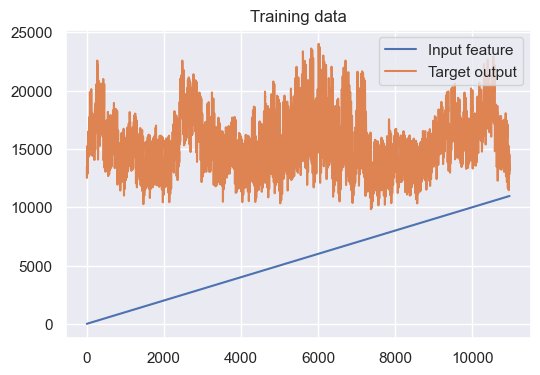

In [6]:
# Let's visualize the training data
sns.set_theme()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature")
plt.plot(data_y[0, :, 0], label="Target output")
#plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [7]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return optim.Adam(self.model.parameters(), lr=self.lr)

In [8]:
out_features = 1
in_features = 2

wiring = AutoNCP(16, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True, use_swish_activation=False)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


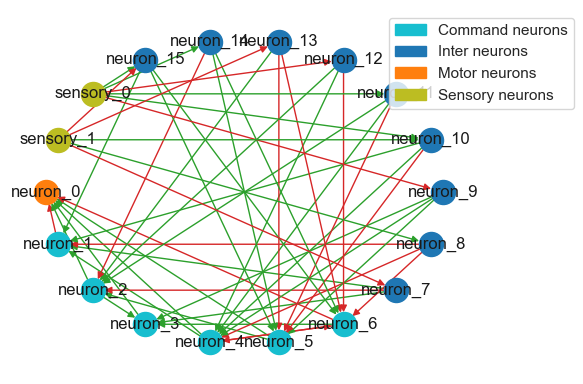

In [9]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

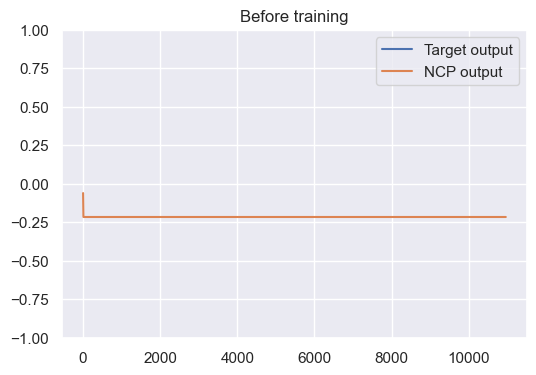

In [10]:
# Let's visualize how LTC initialy performs before the training
sns.set_theme()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [11]:
# Train the model for 400 epochs (= training steps)
trainer.fit(learn, dataloader)

p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 1.5 K  | train
---------------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
p:\Poetry\virtualenvs\ncps-NEh_RkW9-py3.10\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 

Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=2, train_loss=2.53e+8]        

torch.Size([1, 2, 16]) torch.Size([]) torch.Size([2, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 2, 16]) torch.Size([]) torch.Size([2, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 2, 16]) torch.Size([]) torch.Size([2, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.Size([16, 16])
torch.Size([1, 16, 16]) torch.Size([]) torch.S

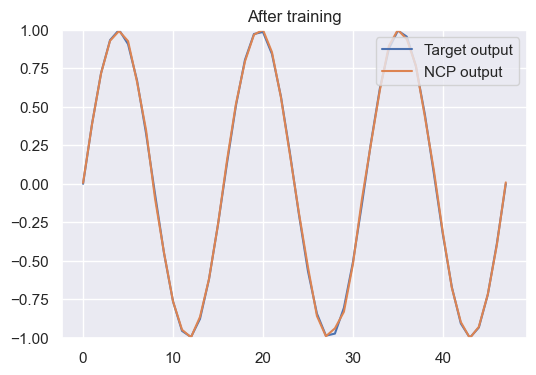

In [15]:
# How does the trained model now fit to the sinusoidal function?
sns.set_theme()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()